# 밀버스를 사용한 멀티모달 RAG
- Milvus, 시각화된 BGE 모델 및 GPT-4o를 사용하여 멀티모달 RAG를 소개
- 사용자가 이미지를 업로드하고 텍스트 지침을 편집하면 BGE의 구성된 검색 모델에서 처리하여 후보 이미지를 검색

## 패키지 설치

- pip install --upgrade pymilvus openai datasets opencv-python timm einops ftfy peft tqdm
- git clone https://github.com/FlagOpen/FlagEmbedding.git 
- cd FlagEmbedding/research/visual_bge
- pip install -e .

## 데이터 다운로드 
- wget https://github.com/milvus-io/bootcamp/releases/download/data/amazon_reviews_2023_subset.tar.gz
- tar -xzf amazon_reviews_2023_subset.tar.gz

## 임베딩 모델 다운로드
- wget https://huggingface.co/BAAI/bge-visualized/resolve/main/Visualized_base_en_v1.5.pth


## 인코더 빌드

In [4]:
import torch
from visual_bge.modeling import Visualized_BGE
class Encoder:
    def __init__(self, model_name: str, model_path: str):
        self.model = Visualized_BGE(model_name_bge=model_name, model_weight=model_path)
        self.model.eval()

    def encode_query(self, image_path: str, text: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path, text=text)
        return query_emb.tolist()[0]

    def encode_image(self, image_path: str) -> list[float]:
        with torch.no_grad():
            query_emb = self.model.encode(image=image_path)
        return query_emb.tolist()[0]


model_name = "BAAI/bge-base-en-v1.5"
model_path = "./Visualized_base_en_v1.5.pth"  # Change to your own value if using a different model path
encoder = Encoder(model_name, model_path)

## 임베딩 생성
- 데이터 디렉토리에서 모든 jpeg 이미지를 로드하고 인코더를 적용하여 이미지를 임베딩으로 변환

In [5]:
import os
from tqdm import tqdm
from glob import glob

data_dir = (
    "./images_folder"
)
image_list = glob(
    os.path.join(data_dir, "images", "*.jpg")
)
image_dict = {}

for image_path in tqdm(image_list, desc="Generating image embeddings: "):
    try:
        image_dict[image_path] = encoder.encode_image(image_path)
    except Exception as e:
        print(f"Failed to generate embedding for {image_path}. Skipped.")
        continue
print("Number of encoded images:", len(image_dict))

Generating image embeddings: 100%|██████████| 900/900 [00:22<00:00, 39.34it/s]

Number of encoded images: 900


## Milvus에 삽입
- 해당 경로와 임베딩이 포함된 이미지를 Milvus 컬렉션에 삽입

인수는 MilvusClient
- uri를 로컬 파일(예: ./milvus_demo.db)로 설정하는 것이 가장 편리한 방법, Milvus Lite가 자동으로 모든 데이터를 이 파일에 저장

- 데이터 규모가 큰 경우, 도커나 쿠버네티스에 더 고성능의 Milvus 서버를 설정할 수 있음

- 밀버스의 완전 관리형 클라우드 서비스인 질리즈 클라우드를 사용하려면, 질리즈 클라우드의 퍼블릭 엔드포인트와 API 키에 해당하는 uri와 token을 조정하세요

In [6]:
from pymilvus import MilvusClient

dim = len(list(image_dict.values())[0])
collection_name = "multimodal_rag_demo"

milvus_client = MilvusClient(uri="./milvus_demo.db")

milvus_client.create_collection(
    collection_name=collection_name,
    auto_id=True,
    dimension=dim,
    enable_dynamic_field=True,
)

milvus_client.insert(
    collection_name=collection_name,
    data=[{"image_path": k, "vector": v} for k, v in image_dict.items()],
)

{'insert_count': 900, 'ids': [459266630747422720, 459266630747422721, 459266630747422722, 459266630747422723, 459266630747422724, 459266630747422725, 459266630747422726, 459266630747422727, 459266630747422728, 459266630747422729, 459266630747422730, 459266630747422731, 459266630747422732, 459266630747422733, 459266630747422734, 459266630747422735, 459266630747422736, 459266630747422737, 459266630747422738, 459266630747422739, 459266630747422740, 459266630747422741, 459266630747422742, 459266630747422743, 459266630747422744, 459266630747422745, 459266630747422746, 459266630747422747, 459266630747422748, 459266630747422749, 459266630747422750, 459266630747422751, 459266630747422752, 459266630747422753, 459266630747422754, 459266630747422755, 459266630747422756, 459266630747422757, 459266630747422758, 459266630747422759, 459266630747422760, 459266630747422761, 459266630747422762, 459266630747422763, 459266630747422764, 459266630747422765, 459266630747422766, 459266630747422767, 4592666307

## 제너레이티브 리랭커로 멀티모달 검색하기
- 이 섹션에서는 먼저 멀티모달 쿼리로 관련 이미지를 검색한 후 LLM 서비스를 사용하여 결과를 재랭크하고 설명이 포함된 최적의 이미지를 찾아봄

## 검색 실행
- 이미지와 텍스트 설명으로 구성된 쿼리 데이터로 고급 이미지 검색을 수행할 준비가 됨

In [7]:
query_image = os.path.join(
    data_dir, "leopard.jpg"
)  # Change to your own query image path
query_text = "phone case with this image theme"

query_vec = encoder.encode_query(image_path=query_image, text=query_text)

search_results = milvus_client.search(
    collection_name=collection_name,
    data=[query_vec],
    output_fields=["image_path"],
    limit=9,  # Max number of search results to return
    search_params={"metric_type": "COSINE", "params": {}},  # Search parameters
)[0]

retrieved_images = [hit.get("entity").get("image_path") for hit in search_results]
print(retrieved_images)


['./images_folder/images/518Gj1WQ-RL._AC_.jpg', './images_folder/images/41n00AOfWhL._AC_.jpg', './images_folder/images/51Wqge9HySL._AC_.jpg', './images_folder/images/51R2SZiywnL._AC_.jpg', './images_folder/images/516PebbMAcL._AC_.jpg', './images_folder/images/51RrgfYKUfL._AC_.jpg', './images_folder/images/515DzQVKKwL._AC_.jpg', './images_folder/images/51BsgVw6RhL._AC_.jpg', './images_folder/images/51INtcXu9FL._AC_.jpg']


# GPT-4o로 순위 재조정
- LLM을 사용하여 이미지의 순위를 매기고 사용자 쿼리와 검색된 결과를 기반으로 최상의 결과에 대한 설명을 생성

In [8]:
# 1. 파노라마 보기 만들기
import numpy as np
import cv2

img_height = 300
img_width = 300
row_count = 3


def create_panoramic_view(query_image_path: str, retrieved_images: list) -> np.ndarray:
    """
    creates a 5x5 panoramic view image from a list of images

    args:
        images: list of images to be combined

    returns:
        np.ndarray: the panoramic view image
    """
    panoramic_width = img_width * row_count
    panoramic_height = img_height * row_count
    panoramic_image = np.full(
        (panoramic_height, panoramic_width, 3), 255, dtype=np.uint8
    )

    # create and resize the query image with a blue border
    query_image_null = np.full((panoramic_height, img_width, 3), 255, dtype=np.uint8)
    query_image = Image.open(query_image_path).convert("RGB")
    query_array = np.array(query_image)[:, :, ::-1]
    resized_image = cv2.resize(query_array, (img_width, img_height))

    border_size = 10
    blue = (255, 0, 0)  # blue color in BGR
    bordered_query_image = cv2.copyMakeBorder(
        resized_image,
        border_size,
        border_size,
        border_size,
        border_size,
        cv2.BORDER_CONSTANT,
        value=blue,
    )

    query_image_null[img_height * 2 : img_height * 3, 0:img_width] = cv2.resize(
        bordered_query_image, (img_width, img_height)
    )

    # add text "query" below the query image
    text = "query"
    font_scale = 1
    font_thickness = 2
    text_org = (10, img_height * 3 + 30)
    cv2.putText(
        query_image_null,
        text,
        text_org,
        cv2.FONT_HERSHEY_SIMPLEX,
        font_scale,
        blue,
        font_thickness,
        cv2.LINE_AA,
    )

    # combine the rest of the images into the panoramic view
    retrieved_imgs = [
        np.array(Image.open(img).convert("RGB"))[:, :, ::-1] for img in retrieved_images
    ]
    for i, image in enumerate(retrieved_imgs):
        image = cv2.resize(image, (img_width - 4, img_height - 4))
        row = i // row_count
        col = i % row_count
        start_row = row * img_height
        start_col = col * img_width

        border_size = 2
        bordered_image = cv2.copyMakeBorder(
            image,
            border_size,
            border_size,
            border_size,
            border_size,
            cv2.BORDER_CONSTANT,
            value=(0, 0, 0),
        )
        panoramic_image[
            start_row : start_row + img_height, start_col : start_col + img_width
        ] = bordered_image

        # add red index numbers to each image
        text = str(i)
        org = (start_col + 50, start_row + 30)
        (font_width, font_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2
        )

        top_left = (org[0] - 48, start_row + 2)
        bottom_right = (org[0] - 48 + font_width + 5, org[1] + baseline + 5)

        cv2.rectangle(
            panoramic_image, top_left, bottom_right, (255, 255, 255), cv2.FILLED
        )
        cv2.putText(
            panoramic_image,
            text,
            (start_col + 10, start_row + 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 0, 255),
            2,
            cv2.LINE_AA,
        )

    # combine the query image with the panoramic view
    panoramic_image = np.hstack([query_image_null, panoramic_image])
    return panoramic_image


In [ ]:
from PIL import Image

combined_image_path = os.path.join(data_dir, "combined_image.jpg")
panoramic_image = create_panoramic_view(query_image, retrieved_images)
cv2.imwrite(combined_image_path, panoramic_image)

combined_image = Image.open(combined_image_path)
show_combined_image = combined_image.resize((300, 300))
show_combined_image.show()


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


## 재랭크 및 설명

In [ ]:
import requests
import base64

OPEN_API_KEY = ""
openai_api_key = OPEN_API_KEY


def generate_ranking_explanation(
    combined_image_path: str, caption: str, infos: dict = None
) -> tuple[list[int], str]:
    with open(combined_image_path, "rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    information = (
        "You are responsible for ranking results for a Composed Image Retrieval. "
        "The user retrieves an image with an 'instruction' indicating their retrieval intent. "
        "For example, if the user queries a red car with the instruction 'change this car to blue,' a similar type of car in blue would be ranked higher in the results. "
        "Now you would receive instruction and query image with blue border. Every item has its red index number in its top left. Do not misunderstand it. "
        f"User instruction: {caption} \n\n"
    )

    # add additional information for each image
    if infos:
        for i, info in enumerate(infos["product"]):
            information += f"{i}. {info}\n"

    information += (
        "Provide a new ranked list of indices from most suitable to least suitable, followed by an explanation for the top 1 most suitable item only. "
        "The format of the response has to be 'Ranked list: []' with the indices in brackets as integers, followed by 'Reasons:' plus the explanation why this most fit user's query intent."
    )

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {openai_api_key}",
    }

    payload = {
        "model": "gpt-4o",
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": information},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                    },
                ],
            }
        ],
        "max_tokens": 300,
    }

    response = requests.post(
        "https://api.openai.com/v1/chat/completions", headers=headers, json=payload
    )
    result = response.json()["choices"][0]["message"]["content"]

    # parse the ranked indices from the response
    start_idx = result.find("[")
    end_idx = result.find("]")
    ranked_indices_str = result[start_idx + 1 : end_idx].split(",")
    ranked_indices = [int(index.strip()) for index in ranked_indices_str]

    # extract explanation
    explanation = result[end_idx + 1 :].strip()

    return ranked_indices, explanation


In [11]:
ranked_indices, explanation = generate_ranking_explanation(
    combined_image_path, query_text
)

Reasons: 

The most suitable item is index 6 because it features a leopard pattern that closely matches the theme of the leopard image in the query. The case design directly reflects the spotted pattern and color palette associated with the leopard, aligning well with the user's instruction to have a phone case with this image theme.


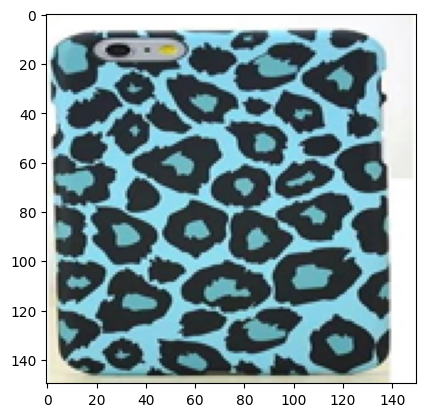

In [13]:
import matplotlib.pyplot as plt

print(explanation)

best_index = ranked_indices[0]
best_img = Image.open(retrieved_images[best_index])
best_img = best_img.resize((150, 150))

plt.imshow(best_img)